###### Forecst Store Sales using a Kaggle Dataset
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

# Import Libraries and load the data

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_log_error
#from sklearn.metrics import mean_squared_error

In [375]:
# load all the data files into dataframes

df_train = pd.read_csv('data/train.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
df_test = pd.read_csv('data/test.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
df_holidays = pd.read_csv('data/holidays_events.csv', parse_dates = ['date'], infer_datetime_format = True)
df_oil = pd.read_csv('data/oil.csv',  parse_dates = ['date'], infer_datetime_format = True)
df_sample_submission = pd.read_csv('data/sample_submission.csv',index_col='id')
df_stores = pd.read_csv('data/stores.csv')
df_transactions = pd.read_csv('data/transactions.csv',  parse_dates = ['date'], infer_datetime_format = True)

## Profile training data frame

In [293]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 137.4+ MB


In [296]:
df_train.sample(20)

,date,store_nbr,family,sales,onpromotion
id,,,,,
53395,2013-01-30,8,BABY CARE,0.000,0
1237410,2014-11-27,29,DELI,0.000,0
404809,2013-08-16,17,SCHOOL AND OFFICE SUPPLIES,0.000,0
2503379,2016-11-08,49,SEAFOOD,81.473,2
2647238,2017-01-29,36,FROZEN FOODS,163.577,0
2505420,2016-11-09,7,PLAYERS AND ELECTRONICS,15.000,0
236148,2013-05-13,35,AUTOMOTIVE,2.000,0
825422,2014-04-10,19,PET SUPPLIES,0.000,0
657469,2014-01-05,7,EGGS,347.000,0


In [331]:
#aggregate sales at the daily level to check trends
aggr_sales = pd.DataFrame(df_train.groupby('date').agg({'sales': 'sum'}))
pd.options.display.float_format = '{:.2f}'.format
aggr_sales.describe()

,sales
count,1684.00
mean,637556.38
std,234410.24
min,2511.62
25%,442711.49
50%,632188.86
75%,785945.48
max,1463083.96


Text(0.5, 1.0, 'Trend of Overall Sales')

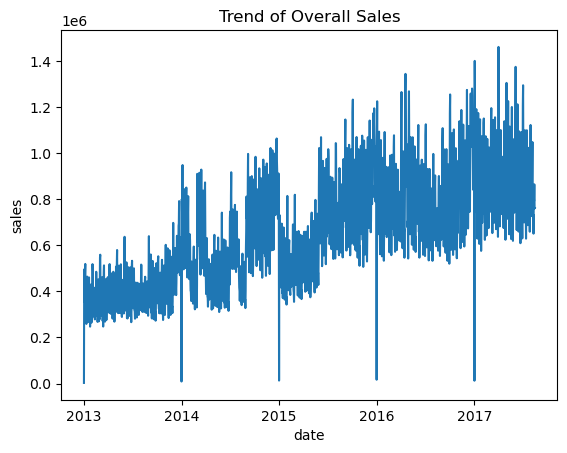

In [325]:
sns.lineplot(data=df_train.groupby('date').agg({'sales': 'sum'}),  x='date', y='sales').set_title('Trend of Overall Sales')

In [347]:
aggr_sales.loc[['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']]

,sales
date,
2013-01-01,2511.62
2014-01-01,8602.07
2015-01-01,12773.62
2016-01-01,16433.39
2017-01-01,12082.50


,sales
date,
2013-01-01,2511.62
2014-01-01,8602.07


## Profile holidays data frame

Notes from Kaggle for Holidays and Events, with metadata
NOTE: 

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [348]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [349]:
df_holidays.sample(25)

,date,type,locale,locale_name,description,transferred
333,2017-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
60,2013-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
110,2014-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
294,2016-12-25,Holiday,National,Ecuador,Navidad,False
231,2016-04-27,Event,National,Ecuador,Terremoto Manabi+11,False
292,2016-12-23,Additional,National,Ecuador,Navidad-2,False
116,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
253,2016-05-15,Event,National,Ecuador,Terremoto Manabi+29,False
192,2015-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
26,2012-11-11,Holiday,Local,Latacunga,Independencia de Latacunga,False


## Profile Stores dataframe
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores

In [350]:
df_stores.sample(25)

,store_nbr,city,state,type,cluster
6,7,Quito,Pichincha,D,8
15,16,Santo Domingo,Santo Domingo de los Tsachilas,C,3
5,6,Quito,Pichincha,D,13
21,22,Puyo,Pastaza,C,7
32,33,Quevedo,Los Rios,C,3
0,1,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
50,51,Guayaquil,Guayas,A,17
53,54,El Carmen,Manabi,C,3
20,21,Santo Domingo,Santo Domingo de los Tsachilas,B,6


Text(0.5, 1.0, 'Number of Stores by Type and Cluster')

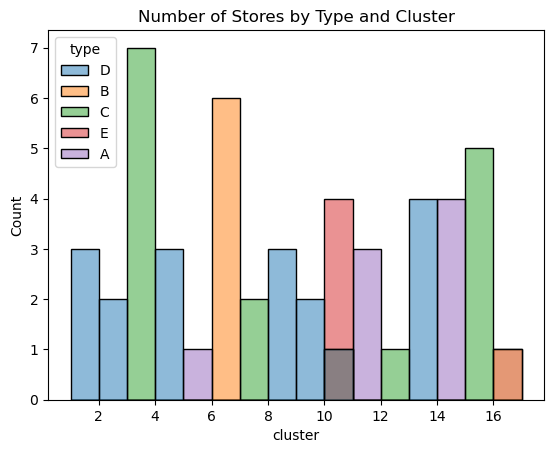

In [351]:
sns.histplot(data = df_stores
            , x='cluster'
            , hue='type'
            ,binwidth = 1).set_title('Number of Stores by Type and Cluster')

### Findings
* Store type and Store Cluster seem to be providing similar information. Only Cluster 10 has 2 different types of stores in it

## Profile the oil datframe
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [7]:
df_oil.head(20)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [8]:
df_oil.tail(20)

,date,dcoilwtico
1198,2017-08-04,49.57
1199,2017-08-07,49.37
1200,2017-08-08,49.07
1201,2017-08-09,49.59
1202,2017-08-10,48.54
1203,2017-08-11,48.81
1204,2017-08-14,47.59
1205,2017-08-15,47.57
1206,2017-08-16,46.80
1207,2017-08-17,47.07


In [9]:
# find null values
df_oil[df_oil['dcoilwtico'].isnull()].count()

date          43
dcoilwtico     0
dtype: int64

Text(0.5, 1.0, 'Trend of Oil Prices')

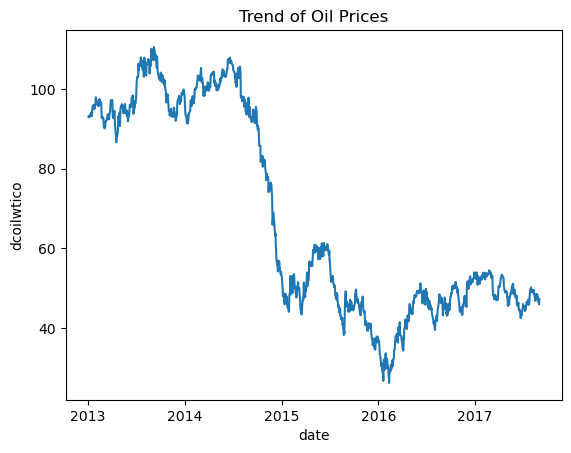

In [10]:
sns.lineplot(data=df_oil,  x='date', y='dcoilwtico').set_title('Trend of Oil Prices')

### Findings
* The datasets starts with 0 and there are several missing values
* There is a step function drop arund 2015 and several peaks and drops in the dataset
* The time series has missing dates as well




# Profile the transactions dataset

In [354]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [355]:
df_transactions.head(15)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [356]:
df_transactions.tail(5)

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [358]:
df_transactions.store_nbr.unique()

array([25,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39,
       40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 36, 53, 20, 29, 21,
       42, 22, 52])

In [15]:
#sns.lineplot(data=df_transactions
#             ,  x='date'
#             , y='sales'
#            ,hue='store_nbr').set_title('Trend of Sales by Store')

## Profile Test data frame

In [361]:
df_test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [362]:
df_test.tail()

,date,store_nbr,family,onpromotion
id,,,,
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
3029399,2017-08-31,9,SEAFOOD,0


In [363]:
df_test.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

## Feature Engineering and creating the final Train and Test datasets
* Add store location and Cluster/Type data to test and train dataset
* Holiday dataset so that it is an additional regressor at the store and region level
* Oil dataset so that it is an additional regressor
* Store dataset to get stores in same regons that might be running promotions that impact sales
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake

### Add store location and cluster data to train and test
* This will be used to add regional and local holidays
* This will also be used to add items that are on promo in nearby stores

In [376]:
df_train = pd.merge(df_train,df_stores , how="left", on="store_nbr").copy()
df_test = pd.merge(df_test,df_stores , how="left", on="store_nbr").copy()

In [377]:
df_train

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.00,0,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.00,0,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.00,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.13,0,Quito,Pichincha,B,6
3000884,2017-08-15,9,PREPARED FOODS,154.55,1,Quito,Pichincha,B,6
3000885,2017-08-15,9,PRODUCE,2419.73,148,Quito,Pichincha,B,6
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,Quito,Pichincha,B,6


### Feature engineering on the holidays

Notes from Kaggle for Holidays and Events, with metadata
NOTE: 

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [378]:
# create a time series for holidays
# create a time series dataframe from start to an additional 15 days that need to be forecasted
holiday_ts = pd.DataFrame(pd.date_range(start='2013-01-01' , end='2017-08-31') , columns=['date'])

In [379]:
#remove holidays that were transferred
df_holiday_clean = df_holidays.query('transferred!=True').copy()
df_holiday_clean.sample(20)

,date,type,locale,locale_name,description,transferred
26,2012-11-11,Holiday,Local,Latacunga,Independencia de Latacunga,False
115,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
270,2016-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
168,2015-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
25,2012-11-10,Holiday,Local,Guaranda,Independencia de Guaranda,False
15,2012-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
186,2015-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
132,2014-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


In [380]:
# national holidays, additional days and events
df_national_holiday = df_holiday_clean.query("locale=='National' and type!='Work Day'")[['date']].copy()
df_national_holiday["national_holiday_ind"] = 1
df_national_holiday

,date,national_holiday_ind
14,2012-08-10,1
20,2012-10-12,1
21,2012-11-02,1
22,2012-11-03,1
31,2012-12-21,1
...,...,...
345,2017-12-22,1
346,2017-12-23,1
347,2017-12-24,1
348,2017-12-25,1


In [381]:
# add national holiday data to the test and train dataset
df_train = df_train.drop('national_holiday_ind', axis=1, errors='ignore')
df_test = df_test.drop('national_holiday_ind', axis=1, errors='ignore')


df_train = pd.merge(df_train,df_national_holiday , how="left", on="date").copy()
df_test = pd.merge(df_test,df_national_holiday , how="left", on="date").copy()

df_train['national_holiday_ind'].fillna(0, inplace=True)
df_test['national_holiday_ind'].fillna(0, inplace=True)

df_train.sample(25)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,national_holiday_ind
67055,2013-02-07,4,SEAFOOD,15.49,0,Quito,Pichincha,D,9,0.00
2965122,2017-07-22,6,CELEBRATION,22.00,0,Quito,Pichincha,D,13,0.00
2082637,2016-03-16,44,CLEANING,2363.00,4,Quito,Pichincha,A,5,0.00
95950,2013-02-23,50,LADIESWEAR,0.00,0,Ambato,Tungurahua,A,14,0.00
701930,2014-01-30,53,LAWN AND GARDEN,0.00,0,Manta,Manabi,D,13,0.00
1752581,2015-09-12,33,HOME APPLIANCES,0.00,0,Quevedo,Los Rios,C,3,0.00
229679,2013-05-09,52,SEAFOOD,0.00,0,Manta,Manabi,A,11,0.00
1018477,2014-07-27,35,SCHOOL AND OFFICE SUPPLIES,0.00,0,Playas,Guayas,C,3,0.00
2223147,2016-05-31,37,BEVERAGES,2627.00,43,Cuenca,Azuay,D,2,0.00
640595,2013-12-27,32,SEAFOOD,1.00,0,Guayaquil,Guayas,C,3,0.00


In [384]:
#regional holidays
df_regional_holiday = df_holiday_clean.query("locale=='Regional' and type!='Work Day'")[['date','locale_name']].copy()
df_regional_holiday["regional_holiday_ind"] = 1
df_regional_holiday.sample(10)

,date,locale_name,regional_holiday_ind
23,2012-11-06,Santo Domingo de los Tsachilas,1
194,2015-11-07,Santa Elena,1
315,2017-06-25,Imbabura,1
278,2016-11-06,Santo Domingo de los Tsachilas,1
193,2015-11-06,Santo Domingo de los Tsachilas,1
1,2012-04-01,Cotopaxi,1
140,2014-11-07,Santa Elena,1
96,2014-04-01,Cotopaxi,1
165,2015-04-01,Cotopaxi,1
47,2013-04-01,Cotopaxi,1


In [385]:
df_train = df_train.drop('regional_holiday_ind', axis=1, errors='ignore')
df_test = df_test.drop('regional_holiday_ind', axis=1, errors='ignore')


df_train = pd.merge(df_train,df_regional_holiday , how="left", left_on=["date", "state"] 
                    ,right_on=["date", "locale_name"]).copy()
df_test = pd.merge(df_test,df_regional_holiday , how="left", left_on=["date", "state"]   
                   ,right_on=["date", "locale_name"] ).copy()

df_train['regional_holiday_ind'].fillna(0, inplace=True)
df_test['regional_holiday_ind'].fillna(0, inplace=True)

In [390]:
df_test.drop('locale_name', axis=1, inplace=True)
df_train.drop('locale_name', axis=1,inplace=True)


df_test.sample(25)

,date,store_nbr,family,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind
23388,2017-08-29,15,MEATS,0,Ibarra,Imbabura,C,15,0.00,0.00
11702,2017-08-22,37,LAWN AND GARDEN,0,Cuenca,Azuay,D,2,0.00,0.00
815,2017-08-16,31,MAGAZINES,0,Babahoyo,Los Rios,B,10,0.00,0.00
3489,2017-08-17,7,MEATS,0,Quito,Pichincha,D,8,0.00,0.00
15481,2017-08-24,43,BOOKS,0,Esmeraldas,Esmeraldas,E,10,0.00,0.00
11580,2017-08-22,33,PRODUCE,102,Quevedo,Los Rios,C,3,0.00,0.00
4999,2017-08-18,49,HOME AND KITCHEN II,2,Quito,Pichincha,A,11,0.00,0.00
2441,2017-08-17,27,SEAFOOD,0,Daule,Guayas,D,1,0.00,0.00
1222,2017-08-16,43,BABY CARE,0,Esmeraldas,Esmeraldas,E,10,0.00,0.00
25653,2017-08-30,29,GROCERY I,73,Guayaquil,Guayas,E,10,0.00,0.00


In [124]:
#local holidays
df_local_holiday = df_holiday_clean.query("locale=='Local' and type!='Work Day'")
df_local_holiday.sample(10)


,date,type,locale,locale_name,description,transferred
282,2016-11-12,Holiday,Local,Ambato,Independencia de Ambato,False
68,2013-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
262,2016-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
175,2015-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
164,2015-03-02,Holiday,Local,Manta,Fundacion de Manta,False
197,2015-11-12,Holiday,Local,Ambato,Independencia de Ambato,False
301,2017-03-02,Holiday,Local,Manta,Fundacion de Manta,False
287,2016-12-06,Holiday,Local,Quito,Fundacion de Quito,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
263,2016-07-23,Holiday,Local,Cayambe,Cantonizacion de Cayambe,False


### A magnitude 7.8 earthquake struck Ecuador on April 16, 2016

In [391]:
print(df_holidays[df_holidays['date'] == '2016-04-16'])
#df_train['national_holiday_ind'].mask(df_train['date'] == '2016-04-16', 1, inplace=True)

          date   type    locale locale_name       description  transferred
219 2016-04-16  Event  National     Ecuador  Terremoto Manabi        False


### Feature engineering on the oil dataset
* Filling missing values and added it to the test and train dataset
* adding missing dates to the dataset

In [392]:
# create a time series dataframe from start to an additional 15 days that need to be forecasted
oil_ts = pd.DataFrame(pd.date_range(start='2013-01-01' , end='2017-08-31') , columns=['date'])

In [393]:
# merge the oil data into the new dataframe so that there are no missing dates
oil_ts = pd.merge(oil_ts,df_oil , how="left", on="date").copy()

In [394]:
oil_ts.head(20)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN
5,2013-01-06,NaN
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


In [395]:
oil_ts.tail(20)

,date,dcoilwtico
1684,2017-08-12,NaN
1685,2017-08-13,NaN
1686,2017-08-14,47.59
1687,2017-08-15,47.57
1688,2017-08-16,46.80
1689,2017-08-17,47.07
1690,2017-08-18,48.59
1691,2017-08-19,NaN
1692,2017-08-20,NaN
1693,2017-08-21,47.39


In [396]:
# fill the oil data that is missing with the next non missing value
oil_ts['dcoilwtico'].fillna(method='backfill', inplace=True)

In [397]:
oil_ts[oil_ts['dcoilwtico'].isnull()]

,date,dcoilwtico


In [398]:
# add oil data to the test and train dataset
df_train = df_train.drop('dcoilwtico', axis=1, errors='ignore')
df_test = df_test.drop('dcoilwtico', axis=1, errors='ignore')


df_train = pd.merge(df_train,oil_ts , how="left", on="date").copy()
df_test = pd.merge(df_test,oil_ts , how="left", on="date").copy()
df_train.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14
1,2013-01-01,1,BABY CARE,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14
2,2013-01-01,1,BEAUTY,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14
3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14
4,2013-01-01,1,BOOKS,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14


### Create a dataset that has indicators for dates when wages are paid

In [399]:
#create the wages dataset
wages_ts = pd.DataFrame(pd.date_range(start='2013-01-01' , end='2017-08-31') , columns=['date'])

In [400]:
#indicator for 15th and last day of each month

wages_ts = wages_ts.drop('is_salary_day', axis=1, errors='ignore')

def wage_dates(col):
    if col['date'].is_month_end or col['date'].day==15:
        return 1
    else:
        return 0

wages_ts['is_salary_day'] = wages_ts.apply(wage_dates, axis=1)

wages_ts.head(60)

,date,is_salary_day
0,2013-01-01,0
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0
5,2013-01-06,0
6,2013-01-07,0
7,2013-01-08,0
8,2013-01-09,0
9,2013-01-10,0


In [401]:
# add wage days to the train and test dataset
df_train = df_train.drop('is_salary_day', axis=1, errors='ignore')
df_train = pd.merge(df_train,wages_ts , how="left", on="date").copy()

df_test = df_test.drop('is_salary_day', axis=1, errors='ignore')
df_test = pd.merge(df_test,wages_ts , how="left", on="date").copy()

In [402]:
df_train.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,dcoilwtico,is_salary_day
0,2013-01-01,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14,0
1,2013-01-01,1,BABY CARE,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14,0
2,2013-01-01,1,BEAUTY,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14,0
3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14,0
4,2013-01-01,1,BOOKS,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14,0


## Train the Prophet model for a single store and family to build framework

In [403]:
#creaate a copy and check the data types
df_train_p = pd.DataFrame()
df_train_p = df_train.query("store_nbr == 1 and family == 'BEVERAGES' ").copy(deep=True)
df_train_p.dtypes

date                    datetime64[ns]
store_nbr                        int64
family                          object
sales                          float64
onpromotion                      int64
city                            object
state                           object
type                            object
cluster                          int64
national_holiday_ind           float64
regional_holiday_ind           float64
dcoilwtico                     float64
is_salary_day                    int64
dtype: object

In [404]:
#rename the columns
df_train_p.rename(columns={'date':'ds','sales':'y'}, inplace=True)

In [405]:
#df_train_p.y = np.log1p(df_train_p.y)

In [406]:
df_train_p.head()

,ds,store_nbr,family,y,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,dcoilwtico,is_salary_day
3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13,1.00,0.00,93.14,0
1785,2013-01-02,1,BEVERAGES,1091.00,0,Quito,Pichincha,D,13,0.00,0.00,93.14,0
3567,2013-01-03,1,BEVERAGES,919.00,0,Quito,Pichincha,D,13,0.00,0.00,92.97,0
5349,2013-01-04,1,BEVERAGES,953.00,0,Quito,Pichincha,D,13,0.00,0.00,93.12,0
7131,2013-01-05,1,BEVERAGES,1160.00,0,Quito,Pichincha,D,13,0.00,0.00,93.20,0


In [407]:
#train the model
model = Prophet()
model.add_regressor('dcoilwtico')
model.add_regressor('is_salary_day')
model.add_regressor('onpromotion')
model.add_regressor('national_holiday_ind')
model.add_regressor('regional_holiday_ind')
model.fit(df_train_p)
model

17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing


In [408]:
#make predictions on the train data
preds = model.predict(df_train_p)
preds.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1683,2017-08-11,2352.79,1330.15,2358.06,2352.79,2352.79,-524.37,-524.37,-524.37,-176.45,...,152.84,152.84,152.84,-252.10,-252.10,-252.10,0.00,0.00,0.00,1828.41
1684,2017-08-12,2352.99,1596.04,2674.59,2352.99,2352.99,-218.44,-218.44,-218.44,-187.78,...,233.78,233.78,233.78,-256.90,-256.90,-256.90,0.00,0.00,0.00,2134.55
1685,2017-08-13,2353.19,578.51,1640.62,2353.19,2353.19,-1255.70,-1255.70,-1255.70,-187.78,...,-794.52,-794.52,-794.52,-259.62,-259.62,-259.62,0.00,0.00,0.00,1097.49
1686,2017-08-14,2353.39,1515.28,2566.52,2353.39,2353.39,-334.04,-334.04,-334.04,-187.78,...,115.29,115.29,115.29,-260.24,-260.24,-260.24,0.00,0.00,0.00,2019.36
1687,2017-08-15,2353.60,1423.52,2500.16,2353.60,2353.60,-386.48,-386.48,-386.48,-187.97,...,61.81,61.81,61.81,-258.76,-258.76,-258.76,0.00,0.00,0.00,1967.12


In [409]:
final_df= pd.concat([preds.set_index('ds'),df_train_p.set_index('ds')], axis=1, join='outer').reset_index()
final_df[['ds','y','yhat']].tail(20)

,ds,y,yhat
1668,2017-07-27,2002.00,2182.17
1669,2017-07-28,2358.00,2339.70
1670,2017-07-29,2161.00,2395.90
1671,2017-07-30,1212.00,1331.53
1672,2017-07-31,2414.00,2242.10
1673,2017-08-01,2627.00,2174.11
1674,2017-08-02,2645.00,2343.82
1675,2017-08-03,2037.00,1999.02
1676,2017-08-04,2479.00,2167.25
1677,2017-08-05,2093.00,2221.19


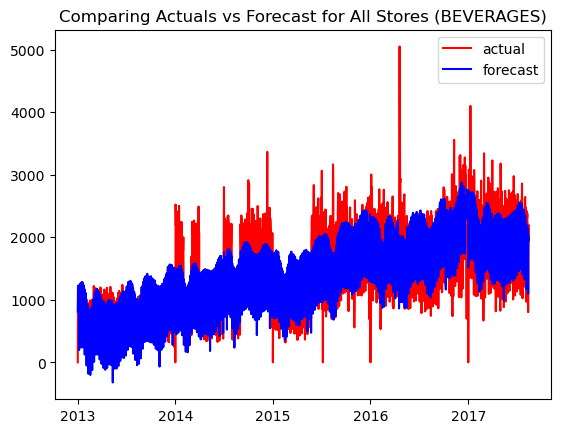

In [410]:
plt.plot(final_df['ds'] , final_df['y'], color='red' , label='actual')
plt.plot(final_df['ds'] , final_df['yhat'], color='blue' , label='forecast')
plt.title('Comparing Actuals vs Forecast for All Stores (BEVERAGES)')
plt.legend()

In [413]:
train_preds = final_df.query("ds<='2017-08-15'")
msle = mean_squared_log_error(abs(train_preds[['y']]) , abs(train_preds[['yhat']]))
print("MSLE is ", msle)                                          

MSLE is  0.3236520635372984


In [89]:
#creaate a copy and check the data types
df_test_p = pd.DataFrame()
df_test_p = df_test.query("store_nbr == 9 and family == 'PREPARED FOODS' ").copy(deep=True)
df_test_p.dtypes

date             datetime64[ns]
store_nbr                 int64
family                   object
onpromotion               int64
dcoilwtico              float64
is_salary_day             int64
dtype: object

,ds,store_nbr,family,onpromotion,dcoilwtico,is_salary_day
28508,2017-08-31,9,PREPARED FOODS,0,NaN,NaN


In [90]:
df_test_p.rename(columns={'date':'ds','sales':'y'}, inplace=True)
preds = model.predict(df_test_p)
final_df= pd.concat([preds.set_index('ds'),df_train_p.set_index('ds')], axis=1, join='outer').reset_index()
final_df[['ds','y','yhat']].tail(20)


,ds,y,yhat
1680,2017-08-12,129.90399,NaN
1681,2017-08-13,105.16900,NaN
1682,2017-08-14,114.12000,NaN
1683,2017-08-15,154.55300,NaN
1684,2017-08-16,NaN,111.561321
1685,2017-08-17,NaN,114.764567
1686,2017-08-18,NaN,108.780765
1687,2017-08-19,NaN,149.422618
1688,2017-08-20,NaN,157.764551
1689,2017-08-21,NaN,117.364329


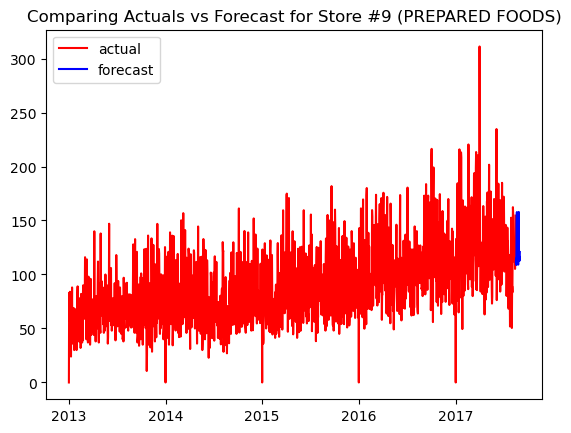

In [91]:
plt.plot(final_df['ds'] , final_df['y'], color='red' , label='actual')
plt.plot(final_df['ds'] , final_df['yhat'], color='blue' , label='forecast')
plt.title('Comparing Actuals vs Forecast for Store #9 (PREPARED FOODS)')
plt.legend()

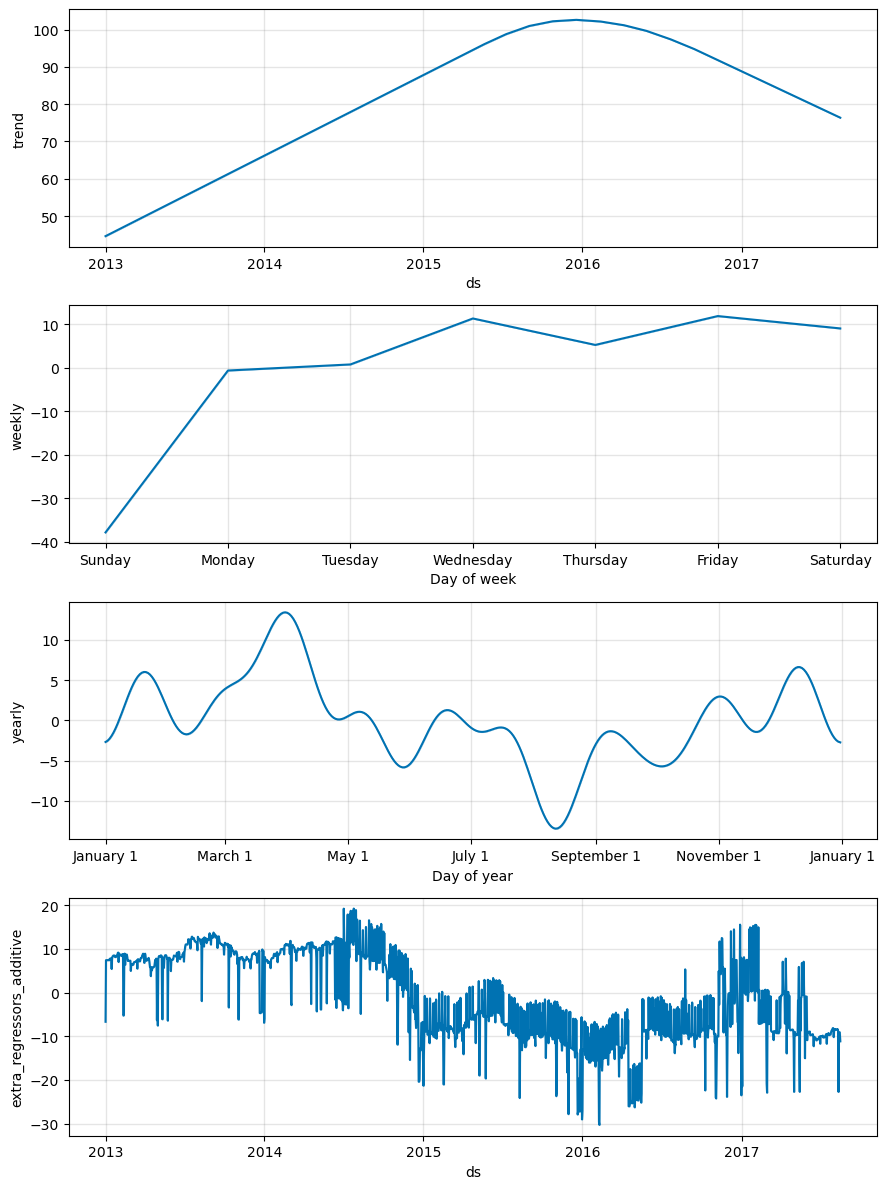

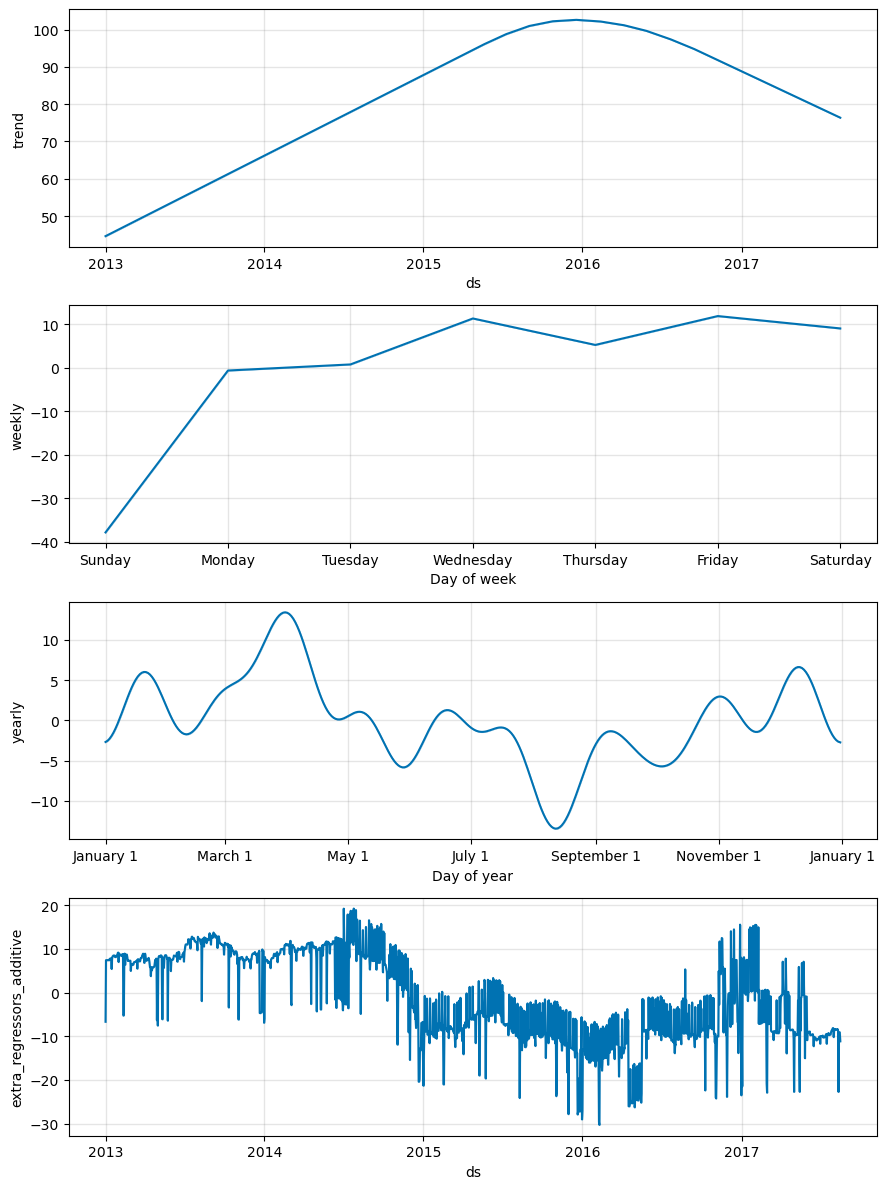

In [213]:
model.plot_components(preds)